# Robustness check using [CheckList](https://github.com/marcotcr/checklist)

Evaluate a LimitedInk DistilBERT model trained on the `movies` dataset.
This notebook only tests the identifier (not the classifier), because the identifier is more interesting and is the novel contribution of the LimitedInk paper.

Borrows heavily from [this tutorial notebook](https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/4.%20The%20CheckList%20process.ipynb).

## Task and model

Load the model and spacy

In [1]:
# Install Checklist and other requirements
import sys
!pip install checklist
!pip install nlp
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 64.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import nltk
nltk.download('omw-1.4')


import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.test_types import MFT, INV, DIR
from checklist.test_suite import TestSuite
from checklist.expect import Expect

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import SequentialSampler, Dataset, DataLoader, TensorDataset

import sys
import spacy
import numpy as np
processor = spacy.load('en_core_web_sm')

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)
state_dict = torch.load('../checkpoints/movies/distilbert/token_rationale/length_level_0.5/seed_1234/models/classifier_ckpt_k0.5.pt')
for key in list(state_dict.keys()):
    state_dict[key[6:]] = state_dict.pop(key)
model.load_state_dict(state_dict)
# sentiment analysis is a general name in Huggingface to load the pipeline for text classification tasks.
# set device=-1 if you don't have a gpu
pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, framework="pt", device=0)

[nltk_data] Downloading package omw-1.4 to /home/wren/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Load the dataset

In [3]:
from utils import utils
from utils.utils_dataloader import set_seed, load_data
import json
import main
import os

train_dataloader, valid_dataloader, test_dataloader = main.train_dataloader, main.valid_dataloader, main.test_dataloader

Loading Dataset...
 === Rationale Level: token === 
Loading features from cached file %s ../data/movies/token/train/token_cached_features_file.pt
Loading Training Set -- Sample Size = 1600
Loading features from cached file %s ../data/movies/token/val/token_cached_features_file.pt
Loading Validation Set -- Sample Size = 200
Loading features from cached file %s ../data/movies/token/test/token_cached_features_file.pt
Loading Test Set -- Sample Size = 199


Preprocess all the questions with spacy.  This may take some time.

In [4]:
# Build all_questions, which consists of strings
from tqdm import tqdm
all_questions = set()
docs_filepath = "../data/movies/docs"
for filename in os.listdir(docs_filepath):
    with open(os.path.join(docs_filepath, filename), "r", encoding="utf-8") as file:
        all_questions.add(file.read())
print(f"Total count of unique questions: {len(all_questions)}")

# Process all_questions
processed_qs = list(tqdm(processor.pipe(all_questions, batch_size=64)))

# Obtain list version of all_questions
all_questions_as_list = list(all_questions)

Total count of unique questions: 1999


1999it [01:29, 22.37it/s]


In [5]:
spacy_map = {q: processed_q for (q, processed_q) in zip(all_questions, processed_qs)}
parsed_qs = [(spacy_map[q]) for q in all_questions]

## Build the CheckList matrix

In [6]:
suite = TestSuite()
editor = Editor()

### Capability: Robustness
> I think this is the only capability Antonis wants us to test.  -Wren

#### MFT (Minimum Functionality Test)

In [7]:
# Actually I dont think we need any MFTs
"""
# When the ground-truth sentiment of a review hinges on a single word, the output should match the sentiment of the word
t = editor.template((
    "This movie is {adjective}."    # Need to alter
    ),
    remove_duplicates=True,
    nsamples=300
    )
test = MFT(**t, labels=0, name="movie descriptors", capability="robustness",
           description="straightforward descriptions of movies")
suite.add(test)
# Show some example prompts
print(t.data[0])
print(t.data[1])
"""

'\n# When the ground-truth sentiment of a review hinges on a single word, the output should match the sentiment of the word\nt = editor.template((\n    "This movie is {adjective}."    # Need to alter\n    ),\n    remove_duplicates=True,\n    nsamples=300\n    )\ntest = MFT(**t, labels=0, name="movie descriptors", capability="robustness",\n           description="straightforward descriptions of movies")\nsuite.add(test)\n# Show some example prompts\nprint(t.data[0])\nprint(t.data[1])\n'

#### INV (Invariance Test)

In [8]:
# Changing contractions should not change the output label
def contractions(q):
    c = Perturb.contractions(q)
    if not c:
        return
    return c

t_contractions = Perturb.perturb(all_questions_as_list, contractions, nsamples=250)
test = INV(**t_contractions, name='contraction invariance', capability='robustness',
          description='')
suite.add(test)
#print(t_contractions.data[0][0])
#print(t_contractions.data[0][1])

In [9]:
# Introducing minor typos should not change the output label
def add_typos(q):
    c = Perturb.add_typos(q, typos=10)
    if not c:
        return
    return c

t_typos = Perturb.perturb(all_questions_as_list, add_typos, nsamples=250)
test = INV(**t_typos, name='typo invariance', capability='robustness',
          description='')
suite.add(test)
#"""
#print(t_typos.data[0][0])
#print(t_typos.data[0][1])

In [10]:
# Changing person names should not change the output label
def change_names(q):
    c = Perturb.change_names(q, seed=1, meta=True)
    if not c:
        return
    # separating out examples and meta. Meta has tuples (a, b), where name 'a' was changed to 'b'
    c, m = c
    # Only include examples where a name was changed
    return [(this_c) for this_c, this_m in zip(c, m) if len(this_m) > 0][:10]

t_names = Perturb.perturb(parsed_qs, change_names, nsamples=25)
test = INV(**t_names, name='person name invariance', capability='robustness',
          description='')
suite.add(test)
#print(t_names.data[0][0])
#print(t_names.data[0][1])
#print(t_names.data[0][2])

#### DIR (Directional Expectation Test)

In [11]:
# Actually I don't think we need any DIRs
"""
# Adding a single sentence that says "This movie is good." at the end should not make the output label more negative.
"""

'\n# Adding a single sentence that says "This movie is good." at the end should not make the output label more negative.\n'

In [12]:
# Actually I don't think we need any DIRs
"""
# Adding a single sentence that says "This movie is bad." at the end should not make the output label more positive.
"""

'\n# Adding a single sentence that says "This movie is bad." at the end should not make the output label more positive.\n'

## Running the suite, seeing results

When running the prediction, the Huggingface pipeline returns a dict with predicted label and probability:

In [13]:
print(pipe(["The movie was bad."]))
print(pipe(["The movie was good."]))

[{'label': 'LABEL_0', 'score': 0.9893769}]
[{'label': 'LABEL_1', 'score': 0.98617023}]


We write a simple wrapper to make the output compatible with CheckList:

In [14]:
def pred_and_conf(data):
    """Prediction and confidence function"""
    raw_preds = pipe(data, pad_to_max_length=True)
    preds = np.array([ int(p["label"][-1]) for p in raw_preds])
    pp = np.array([[p["score"], 1-p["score"]] if int(p["label"][-1]) == 0 else [1-p["score"], p["score"]] for p in raw_preds])
    return preds, pp

In [15]:
# This is how CheckList wants to be run, but it throws errors.
#suite.run(pred_and_conf)



# ----------------------------------------------------------------



# As an alternative, I implemented this approach for getting CheckList results, which runs without errors and uses less VRAM.

def get_score_difference(prediction_old, prediction_new):
    score_old = prediction_old["score"]
    if prediction_old["label"] == "LABEL_0":
        score_old = 1 - score_old
    
    score_new = prediction_new["score"]
    if prediction_new["label"] == "LABEL_0":
        score_new = 1 - score_new

    return score_new - score_old


#
# CONTRACTIONS
#
contractions_score_disturbances = []
for variant_list in t_contractions.data:
    
    # Get the prediction for the unaltered input, on a scale from 0 (certainly NEG) to 1 (certainly POS).
    prediction_on_unaltered = pipe([variant_list[0]])[0]

    # Get score disturbances caused by perturbations
    for passage in variant_list[1:]:
        prediction_on_altered = pipe([passage])[0]
        score_difference = get_score_difference(prediction_on_unaltered, prediction_on_altered)
        contractions_score_disturbances.append(score_difference)
contractions_score_disturbances = np.array(contractions_score_disturbances)


#
# TYPOS
#
typos_score_disturbances = []
for variant_list in t_typos.data:
    
    # Get the prediction for the unaltered input, on a scale from 0 (certainly NEG) to 1 (certainly POS).
    prediction_on_unaltered = pipe([variant_list[0]])[0]

    # Get score disturbances caused by perturbations
    for passage in variant_list[1:]:
        prediction_on_altered = pipe([passage])[0]
        score_difference = get_score_difference(prediction_on_unaltered, prediction_on_altered)
        typos_score_disturbances.append(score_difference)
typos_score_disturbances = np.array(typos_score_disturbances)


#
# NAMES
#
names_score_disturbances = []
for variant_list in t_names.data:
    
    # Get the prediction for the unaltered input, on a scale from 0 (certainly NEG) to 1 (certainly POS).
    prediction_on_unaltered = pipe([variant_list[0]])[0]

    # Get score disturbances caused by perturbations
    for passage in variant_list[1:]:
        prediction_on_altered = pipe([passage])[0]
        score_difference = get_score_difference(prediction_on_unaltered, prediction_on_altered)
        names_score_disturbances.append(score_difference)
names_score_disturbances = np.array(names_score_disturbances)


#
# SHOW RESULTS
#
print("CONTRACTIONS")
print(f"{len(t_contractions.data)} source inputs, {len(t_contractions.data[0])-1} variants per input")
print(f"Average score disturbance magnitude: {np.mean(abs(contractions_score_disturbances)):.3E}")
print(f"Average score disturbance: {np.mean(contractions_score_disturbances):.3E}")
print(f"Standard deviation: {np.std(contractions_score_disturbances):.3E}")
print(f"Most negative score disturbance: {np.min(contractions_score_disturbances):.3E}")
print(f"Most positive score disturbance: {np.max(contractions_score_disturbances):.3E}")
print("_" * 64)

print("TYPOS")
print(f"{len(t_typos.data)} source inputs, {len(t_typos.data[0])-1} variants per input")
print(f"Average score disturbance magnitude: {np.mean(abs(typos_score_disturbances)):.3E}")
print(f"Average score disturbance: {np.mean(typos_score_disturbances):.3E}")
print(f"Standard deviation: {np.std(typos_score_disturbances):.3E}")
print(f"Most negative score disturbance: {np.min(typos_score_disturbances):.3E}")
print(f"Most positive score disturbance: {np.max(typos_score_disturbances):.3E}")
print("_" * 64)

print("NAMES")
print(f"{len(t_names.data)} source inputs, {len(t_names.data[0])-1} variants per input")
print(f"Average score disturbance magnitude: {np.mean(abs(names_score_disturbances)):.3E}")
print(f"Average score disturbance: {np.mean(names_score_disturbances):.3E}")
print(f"Standard deviation: {np.std(names_score_disturbances):.3E}")
print(f"Most negative score disturbance: {np.min(names_score_disturbances):.3E}")
print(f"Most positive score disturbance: {np.max(names_score_disturbances):.3E}")
print("_" * 64)

CONTRACTIONS
250 source inputs, 1 variants per input
Average score disturbance magnitude: 1.590E-02
Average score disturbance: -1.256E-03
Standard deviation: 9.388E-02
Most negative score disturbance: -6.558E-01
Most positive score disturbance: 9.710E-01
________________________________________________________________
TYPOS
250 source inputs, 1 variants per input
Average score disturbance magnitude: 2.109E-02
Average score disturbance: -8.524E-03
Standard deviation: 9.658E-02
Most negative score disturbance: -8.813E-01
Most positive score disturbance: 7.506E-01
________________________________________________________________
NAMES
25 source inputs, 10 variants per input
Average score disturbance magnitude: 1.012E-03
Average score disturbance: 7.866E-04
Standard deviation: 4.881E-03
Most negative score disturbance: -3.184E-03
Most positive score disturbance: 3.949E-02
________________________________________________________________


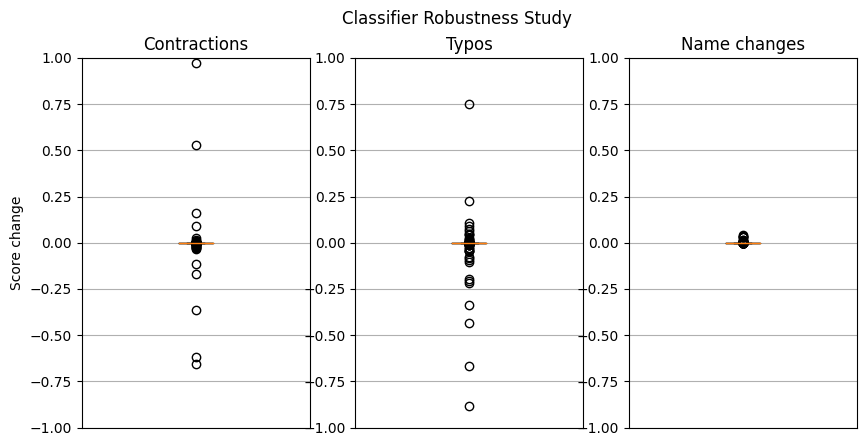

In [55]:
# Plot results as box-and-whisker plots
from matplotlib import pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(10)
fig.suptitle("Classifier Robustness Study")
ax1.set_title("Contractions")
ax1.boxplot(contractions_score_disturbances)
ax1.set_ylim(-1, 1)
ax1.set_ylabel("Score change")
ax1.get_xaxis().set_visible(False)
ax1.grid()
ax2.set_title("Typos")
ax2.boxplot(typos_score_disturbances)
ax2.set_ylim(-1, 1)
ax2.get_xaxis().set_visible(False)
ax2.grid()
ax3.set_title("Name changes")
ax3.boxplot(names_score_disturbances)
ax3.set_ylim(-1, 1)
ax3.get_xaxis().set_visible(False)
ax3.grid()
plt.show()